## Purpose
The purpose of this application is to inspect the prostate dataset that we intend
to use for the project in 02450 Intro to Machine Learning

Author: Greta Tuckute
Reviewed by: 
Last modified: 28/010/18, 09.09

#### Change-log


Import required packages

In [72]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from scipy.linalg import svd
from matplotlib.pyplot import figure, plot, subplot, title, xlabel, ylabel, show, clim, hist, savefig
import sklearn.linear_model as lm
import os
import neurolab as nl


First we define a method for importing a spread_sheet using pandas

In [73]:
def DataLoader(path, sheet):
    """
    Method for importing data from a spreadsheet.

    :param path: full path to the spreadsheet to load
    :param sheet: name of the sheet in the workbook that is loaded
    :return: pandas dataFrame with imported data
    """
    import pandas as pd

    out = pd.read_excel(path, sheet_name=sheet)

    return out

In [74]:
# Specify path and sheet name in the prostate workbook

base_dir = os.getcwd()
filePath = base_dir + '/Data/Prostate.xlsx'
#filePath = 'C:/Users/PeterBakke/Documents/git/ML_fall2018/Data/Prostate.xlsx'
#filePath = 'C:/Users/Greta/Documents/Github/ML_fall2018/Data/Prostate.xlsx'
#filePath = 'C:/Users/narisa/Documents/GitHub/ML_fall2018/Data/Prostate.xlsx'
sheet = 'Sheet1'

In [75]:
# Load prostate data into dataFrame
myData = DataLoader(path=filePath, sheet=sheet)

# delete irrelevant columns
del myData['ID']
del myData['train']


### Data feature extraction and normalization

In [76]:
# If we apply one out of K encoding to Gleason/PGG45, we assume that a higher value is not informative of disease result?

# Usually done for ordinal (not often for nominal)

# Do NOT normalise categorical data

In [77]:
# Extract class names 
attributeNames = list(myData.columns.values)

# Convert dataFrame to numpy array
X = myData.values

# Compute values of N (observations) and M (features)
M = len(attributeNames)
N = X.shape[0]

print(attributeNames)

['lCaVol', 'lWeight', 'Age', 'lBPH', 'SVI', 'lCP', 'Gleason', 'pgg45', 'lPSA']


In [78]:
# Extracting and deleting PGG45 and Gleason from X, as well as SVI (to not normalize SVI)
X_orig = np.copy(X)

gleason = X_orig[:,6]
pgg = X_orig[:,7]
svi = X_orig[:,4]

# print(X)

In [79]:
# OBS - only run this once
X = np.delete(X,6,1) # Deletes Gleason
X = np.delete(X,6,1) # Deletes PGG
X = np.delete(X,4,1) # Deletes SVI

In [80]:
print(X.shape)
print(X)

(97, 6)
[[-5.79818495e-01  2.76945900e+00  5.00000000e+01 -1.38629436e+00
  -1.38629436e+00 -4.30782900e-01]
 [-9.94252273e-01  3.31962600e+00  5.80000000e+01 -1.38629436e+00
  -1.38629436e+00 -1.62518900e-01]
 [-5.10825624e-01  2.69124300e+00  7.40000000e+01 -1.38629436e+00
  -1.38629436e+00 -1.62518900e-01]
 [-1.20397280e+00  3.28278900e+00  5.80000000e+01 -1.38629436e+00
  -1.38629436e+00 -1.62518900e-01]
 [ 7.51416089e-01  3.43237300e+00  6.20000000e+01 -1.38629436e+00
  -1.38629436e+00  3.71563600e-01]
 [-1.04982212e+00  3.22882600e+00  5.00000000e+01 -1.38629436e+00
  -1.38629436e+00  7.65467800e-01]
 [ 7.37164066e-01  3.47351800e+00  6.40000000e+01  6.15185640e-01
  -1.38629436e+00  7.65467800e-01]
 [ 6.93147181e-01  3.53950900e+00  5.80000000e+01  1.53686722e+00
  -1.38629436e+00  8.54415300e-01]
 [-7.76528789e-01  3.53950900e+00  4.70000000e+01 -1.38629436e+00
  -1.38629436e+00  1.04731900e+00]
 [ 2.23143551e-01  3.24454400e+00  6.30000000e+01 -1.38629436e+00
  -1.38629436e+00

In [81]:
# Z score all other variables 
X_z = zscore(X)
# print(X_z)

# Current order: lCavol, lWeight, Age, lBPH, lCP, lPSA

In [82]:
# One out of K coding for PGG and Gleason

from categoric2numeric import *

[X_Gleason, attribute_names_Gleason]=categoric2numeric(gleason)
[X_PGG45, attribute_names_PGG45]=categoric2numeric(pgg)

#print(X_Gleason)

In [83]:
print(X_PGG45.shape)
print(np.unique(pgg))
print(svi.shape)
print(X_Gleason.shape)

# 97*30

(97, 19)
[  0.   4.   5.   6.  10.  15.  20.  25.  30.  35.  40.  50.  60.  70.
  75.  80.  90.  95. 100.]
(97,)
(97, 4)


In [84]:
# Add one out of K coded Gleason and PGG columns, as well as SVI 
svi = np.reshape(svi,[97,1])
print(svi.shape)
# X_k = np.concatenate((X,X_Gleason,X_PGG45,svi),axis=1)
X_k = np.concatenate((X_z,X_Gleason,svi),axis=1)

print(X_k.shape)
print(X_k[2])

# Order: lCavol, lWeight, Age, lBPH, lCP, lPSA, Gleason (4 columns), (PGG (19 columns)), SVI (1 column)


(97, 1)
(97, 11)
[-1.58702059 -2.20015441  1.36823439 -1.03002898 -0.86765522 -2.29971238
  0.          1.          0.          0.          0.        ]


### Regression section

In [85]:
# Split dataset into features and target vector
lPSA_idx = 5
# Test lPSA idx:
print(X_k[:,5])

[-2.53331785 -2.29971238 -2.29971238 -2.29971238 -1.83463099 -1.49161747
 -1.49161747 -1.4141616  -1.24618021 -1.24618021 -1.05492666 -1.05492666
 -1.05492666 -0.98428221 -0.94018137 -0.89820677 -0.87795465 -0.85816274
 -0.80135103 -0.76543644 -0.73094466 -0.71419787 -0.68164068 -0.66580745
 -0.65025697 -0.619965   -0.59069151 -0.57641572 -0.54854763 -0.50834947
 -0.48254597 -0.40942861 -0.40942861 -0.39781765 -0.3750503  -0.34197776
 -0.27937807 -0.24968869 -0.23044356 -0.17513581 -0.15745387 -0.14874583
 -0.13158654 -0.09011178  0.0377352   0.06527282  0.07872178  0.07872178
  0.09851369  0.09851369  0.1553254   0.17346783  0.17943223  0.18535613
  0.1970843   0.2086566   0.26969337  0.27503575  0.28562317  0.29086898
  0.31663434  0.32673071  0.32673071  0.35147113  0.35147113  0.35633597
  0.38496775  0.42173538  0.42173538  0.43068977  0.46561391  0.48675094
  0.50329884  0.51953812  0.69391731  0.74816076  0.79630031  0.83354436
  0.85295798  0.90097779  0.90356948  0.91641341  0

In [86]:
y = X_k[:,lPSA_idx] # Extracting the y-label (lPSA)

X_cols = list(range(0,lPSA_idx)) + list(range(lPSA_idx+1,(X_k.shape[1])))
X1 = X_k[:,X_cols] # The new data array without lPSA

print(X1.shape)
print(X1[0])


(97, 10)
[-1.64586143 -2.01663373 -1.87210098 -1.03002898 -0.86765522  1.
  0.          0.          0.          0.        ]


In [87]:
# Creating a new, manual attributeNames for later use
print(attribute_names_Gleason)
print(attribute_names_PGG45)

attributeNamesNew = ['lCaVol', 'lWeight', 'Age', 'lBPH', 'lCP','Gleason 6.0', 'Gleason 7.0', 'Gleason 8.0', 'Gleason 9.0','SVI']


['6.0', '7.0', '8.0', '9.0']
['0.0', '4.0', '5.0', '6.0', '10.0', '15.0', '20.0', '25.0', '30.0', '35.0', '40.0', '50.0', '60.0', '70.0', '75.0', '80.0', '90.0', '95.0', '100.0']


### Forward selection

In [88]:
b = dummy.DummyRegressor(strategy='mean')





C:\Users\PeterBakke\Documents\git\ML_fall2018
Cross validation fold 1/5
Train indices: [ 0  1  3  4  5  6  7  8  9 12 13 14 16 18 19 20 21 22 23 24 26 27 28 29
 30 33 34 35 37 38 39 41 42 43 44 46 47 49 51 54 55 56 57 59 60 61 62 63
 64 65 66 67 68 69 70 71 72 73 75 76 77 78 79 80 82 84 85 86 88 89 90 91
 92 93 94 95 96]
Test indices: [ 2 10 11 15 17 25 31 32 36 40 45 48 50 52 53 58 74 81 83 87]
Features no: 3



Linear regression without feature selection:

- Training error: 0.12136471156011697
- Test error:     0.34855491687440765
- DUMMY Training error: 0.5738848257685816
- DUMMY Test error:     0.9483002762147382

Linear regression with feature selection:
- Training error: 1.0059550098896517
- Test error:     0.37572552726187747
Cross validation fold 2/5
Train indices: [ 1  2  3  4  6  7  8  9 10 11 13 14 15 17 18 19 20 22 23 24 25 26 27 28
 29 31 32 34 35 36 38 39 40 41 42 45 46 47 48 50 51 52 53 54 55 57 58 59
 60 61 63 65 66 67 68 69 70 72 74 75 77 79 81 82 83 84 85 86 87 88 89 

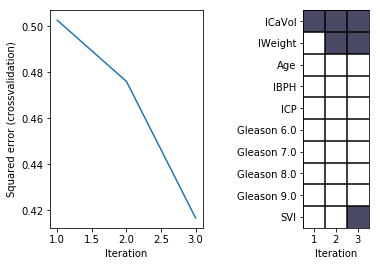

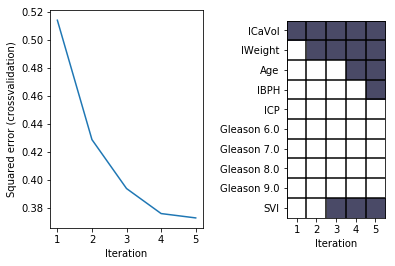

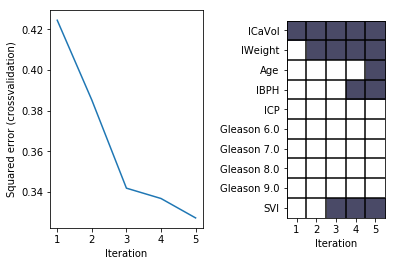

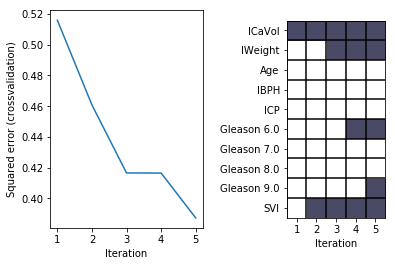

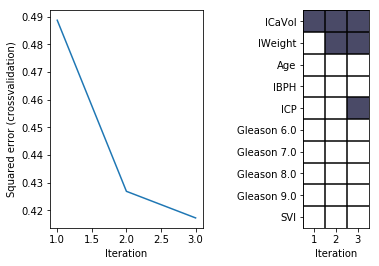

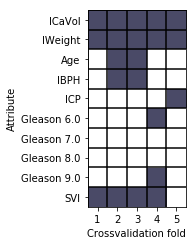

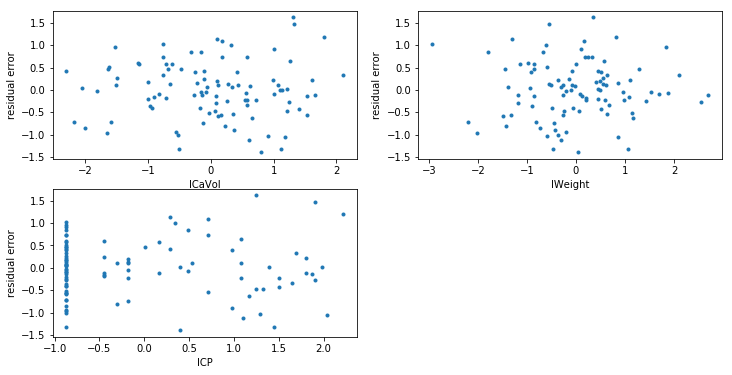

In [89]:
# Forward selection imports
print(os.getcwd())
#os.chdir('C:/Users/Greta/Documents/Github/ML_fall2018/Data/Prostate.xlsx'

from sklearn import model_selection, dummy
from toolbox_02450 import feature_selector_lr, bmplot

N, M = X1.shape

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 5
#seed2 = np.random.randomstate(0)
CV = model_selection.KFold(n_splits=K,shuffle=True, random_state=seed)

# Initialize variables
Features = np.zeros((M,K))
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))

Error_train_b = np.empty((K,1))
Error_test_b = np.empty((K,1))

Error_train_fs = np.empty((K,1))
Error_test_fs = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))

k=0
for train_index, test_index in CV.split(X1):
    
    # extract training and test set for current CV fold
    X_train = X1[train_index,:]
    y_train = y[train_index]
    X_test = X1[test_index,:]
    y_test = y[test_index]
    internal_cross_validation = 10
    
    # Compute squared error without using the input data at all
#     Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum()/y_train.shape[0]
#     Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum()/y_test.shape[0]
    Error_train_nofeatures[k] = np.sqrt(np.square(y_train-y_train.mean()).sum()/y_train.shape[0])
    Error_test_nofeatures[k] = np.sqrt(np.square(y_test-y_test.mean()).sum()/y_test.shape[0])

    # Compute squared error with all features selected (no feature selection)
    m = lm.LinearRegression(fit_intercept=True).fit(X_train, y_train)
    
    # DUMMY
    b = dummy.DummyRegressor(strategy='mean').fit(X_train,y_train)
    
    Error_train_b[k] = np.sqrt(np.square(y_train-b.predict(X_train)).sum()/y_train.shape[0])
    Error_test_b[k] = np.sqrt(np.square(y_test-b.predict(X_test)).sum()/y_test.shape[0])
    
#     Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
#     Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]
    Error_train[k] = np.sqrt(np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0])
    Error_test[k] = np.sqrt(np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0])

    # Compute squared error with feature subset selection
    #textout = 'verbose';
    textout = '';
    selected_features, features_record, loss_record = feature_selector_lr(X_train, y_train, internal_cross_validation,display=textout)
    
    Features[selected_features,k]=1
    # .. alternatively you could use module sklearn.feature_selection
    if len(selected_features) is 0:
        print('No features were selected, i.e. the data (X) in the fold cannot describe the outcomes (y).' )
    else:
        m = lm.LinearRegression(fit_intercept=True).fit(X_train[:,selected_features], y_train)
#         Error_train_fs[k] = np.square(y_train-m.predict(X_train[:,selected_features])).sum()/y_train.shape[0]
#         Error_test_fs[k] = np.square(y_test-m.predict(X_test[:,selected_features])).sum()/y_test.shape[0]
        Error_train_fs[k] = np.sqrt(np.square(y_train-m.predict(X_train[:,selected_features])).sum()/y_train.shape[0])
        Error_test_fs[k] = np.sqrt(np.square(y_test-m.predict(X_test[:,selected_features])).sum()/y_test.shape[0])
    
        figure(k)
        subplot(1,2,1)
        plot(range(1,len(loss_record)), loss_record[1:])
        xlabel('Iteration')
        ylabel('Squared error (crossvalidation)')    
        
        subplot(1,3,3)
        bmplot(attributeNamesNew, range(1,features_record.shape[1]), -features_record[:,1:])
        clim(-1.5,0)
        xlabel('Iteration')

    print('Cross validation fold {0}/{1}'.format(k+1,K))
    print('Train indices: {0}'.format(train_index))
    print('Test indices: {0}'.format(test_index))
    print('Features no: {0}\n'.format(selected_features.size))
    k += 1
    
# Display results
    print('\n')
    print('Linear regression without feature selection:\n')
    print('- Training error: {0}'.format(Error_train.mean()))
    print('- Test error:     {0}'.format(Error_test.mean()))
    
    print('- DUMMY Training error: {0}'.format(Error_train_b.mean()))
    print('- DUMMY Test error:     {0}'.format(Error_test_b.mean()))
    
    #print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
    #print('- R^2 test:     {0}'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
    
    print('\nLinear regression with feature selection:')
    print('- Training error: {0}'.format(Error_train_fs.mean()))
    print('- Test error:     {0}'.format(Error_test_fs.mean()))
    #print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_fs.sum())/Error_train_nofeatures.sum()))
    #print('- R^2 test:     {0}'.format((Error_test_nofeatures.sum()-Error_test_fs.sum())/Error_test_nofeatures.sum()))

    figure(k)
    subplot(1,3,2)
    bmplot(attributeNamesNew, range(1,Features.shape[1]+1), -Features)
    clim(-1.5,0)
    xlabel('Crossvalidation fold') #the internal cross validation fold?
    ylabel('Attribute')
    if k == 5:
        savefig('forward_selection' + str(k) + '.png',dpi=120) #bbox_inches = 'tight'



# Inspect selected feature coefficients effect on the entire dataset and
# plot the fitted model residual error as function of each attribute to
# inspect for systematic structure in the residual

f=5 # cross-validation fold to inspect, overall
ff=Features[:,f-1].nonzero()[0]
if len(ff) is 0:
    print('\nNo features were selected, i.e. the data (X) in the fold cannot describe the outcomes (y).' )
else:
    m = lm.LinearRegression(fit_intercept=True).fit(X1[:,ff], y)
    
    y_est= m.predict(X1[:,ff])
    residual=y-y_est
    
    figure(k+1, figsize=(12,6))
    title('Residual error vs. Attributes for features selected in cross-validation fold {0}'.format(f))
    for i in range(0,len(ff)):
       subplot(2,np.ceil(len(ff)/2.0),i+1)
       plot(X1[:,ff[i]],residual,'.')
       xlabel(attributeNamesNew[ff[i]])
       ylabel('residual error')
        
    savefig('forward_selection_residuals.png',dpi=120) #bbox_inches = 'tight'
    
    
show()

#print(os.getcwd)

In [90]:
print(Error_test_b)
print(Error_test_fs)

[[0.83047872]
 [0.91270637]
 [0.93446195]
 [1.0052705 ]
 [1.29917563]]
[[0.51600767]
 [0.68602747]
 [0.8024087 ]
 [0.62121478]
 [0.67976539]]


### Fit a linear model based on the forward selection above and predict data

In [91]:
# Fit ordinary least squares regression model 

attributeNamesNew = ['lCaVol', 'lWeight', 'Age', 'lBPH', 'lCP','Gleason 6.0', 'Gleason 7.0', 'Gleason 8.0', 'Gleason 9.0','SVI']
lCaVol = X1[:,1]
lCaVol = np.reshape(lCaVol,[97,1])
lWeight = X1[:,2]
lWeight = np.reshape(lWeight,[97,1])
SVI = X1[:,9]
SVI = np.reshape(SVI,[97,1])

print(np.shape(lCaVol))

X_r = np.concatenate((lCaVol,lWeight,SVI),axis=1)

print(np.shape(X_r))
#print(X_r)
print(y)

(97, 1)
(97, 3)
[-2.53331785 -2.29971238 -2.29971238 -2.29971238 -1.83463099 -1.49161747
 -1.49161747 -1.4141616  -1.24618021 -1.24618021 -1.05492666 -1.05492666
 -1.05492666 -0.98428221 -0.94018137 -0.89820677 -0.87795465 -0.85816274
 -0.80135103 -0.76543644 -0.73094466 -0.71419787 -0.68164068 -0.66580745
 -0.65025697 -0.619965   -0.59069151 -0.57641572 -0.54854763 -0.50834947
 -0.48254597 -0.40942861 -0.40942861 -0.39781765 -0.3750503  -0.34197776
 -0.27937807 -0.24968869 -0.23044356 -0.17513581 -0.15745387 -0.14874583
 -0.13158654 -0.09011178  0.0377352   0.06527282  0.07872178  0.07872178
  0.09851369  0.09851369  0.1553254   0.17346783  0.17943223  0.18535613
  0.1970843   0.2086566   0.26969337  0.27503575  0.28562317  0.29086898
  0.31663434  0.32673071  0.32673071  0.35147113  0.35147113  0.35633597
  0.38496775  0.42173538  0.42173538  0.43068977  0.46561391  0.48675094
  0.50329884  0.51953812  0.69391731  0.74816076  0.79630031  0.83354436
  0.85295798  0.90097779  0.9035694

Mean squared error: 0.5569737088290706


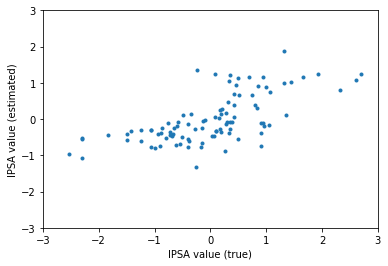

[ 0.35917198 -0.01565832  1.2437635 ]
-0.26926838576385825


In [92]:
from matplotlib.pyplot import figure, plot, xlabel, ylabel, legend, show, xlim, ylim

model = lm.LinearRegression()
model.fit(X_r,y)

# Predict lPSA 
y_est = model.predict(X_r)
residual = y_est-y

# Mean squared error
mse = (sum(residual**2))/len(residual)
print('Mean squared error: ' + str(mse))

# Display scatter plot
figure(1)
plot(y, y_est, '.')
xlim([-3,3]);
ylim([-3,3]);
xlabel('lPSA value (true)'); ylabel('lPSA value (estimated)');
show()

# figure(2)
# plot(X_r,y_est,'-')
# subplot(2,1,2)
# hist(residual,40)
# xlabel('x'); ylabel('Residuals');

# show()

print(model.coef_)
print(model.intercept_)


In [93]:
model.coef_

array([ 0.35917198, -0.01565832,  1.2437635 ])

In [94]:
model.intercept_

-0.26926838576385825

# ANN for regression

In [63]:
# Parameters for neural network classifier
n_hidden_units = [2,4,6,8,10,15]      # number of hidden units
n_train = 6             # number of networks trained in each k-fold
learning_goal = 0.0001     # stop criterion 1 (train mse to be reached)
max_epochs = 512         # stop criterion 2 (max epochs in training)
show_error_freq = 100     # frequency of training status updates



In [64]:
# K-fold crossvalidation
K = 5                   # only three folds to speed up this example
CV = model_selection.KFold(K,shuffle=True, random_state=seed)

In [65]:
# Baseline model

In [66]:
# Baseline model
# def reg_baseline(y_train, y_test):
#     predicted = [int(prediction) for i in range(len(y_test))]
#     return predicted

In [67]:
# Variable for regresson error
errors = np.zeros(K)*np.nan
gen_error = np.zeros(K)*np.nan
error_hist = np.zeros((max_epochs,K))*np.nan
bestnet = list()
k=0
for train_index, test_index in CV.split(X1,y):
    print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K))    
    
    # extract training and test set for current CV fold
    X_train = X1[train_index,:]
    y_train = y[train_index]
    X_test = X1[test_index,:]
    y_test = y[test_index]
    
    best_train_error = np.inf
    for i in range(n_train):
        print('Training network {0}/{1}...'.format(i+1,n_train))
        # Create randomly initialized network with 2 layers
        ann = nl.net.newff([[-3,3]]*M, [n_hidden_units[i], 1], [nl.trans.TanSig(),nl.trans.PureLin()])
        if i==0:
            bestnet.append(ann)
        # train network
        train_error = ann.train(X_train, y_train.reshape(-1,1), goal=learning_goal, epochs=max_epochs, show=show_error_freq, rr=0.3)
        
        if train_error[-1]<best_train_error:
            bestnet[k]=ann
            best_train_error = train_error[-1]
            error_hist[range(len(train_error)),k] = train_error
            best_no_neurons = n_hidden_units[i]

    print('Best train error: {0}...'.format(best_train_error))
    print('Optimal number of hidden neurons: {0}...'.format(best_no_neurons))
    y_est = bestnet[k].sim(X_test).squeeze()
    #y_est = (y_est>.5).astype(int)
    errors[k] = np.power(y_est-y_test,2).sum().astype(float)/y_test.shape[0]
    #errors[k] = 100*(y_est!=y_test).sum().astype(float)/y_test.shape[0]
    gen_error[k] = 100 * (y_est-y_test).sum().astype(float)/y_test.shape[0]
    #errors[k] = - y_test * np.log(y_est) - (1 - y_test) * np.log (1 - y_est)
    print(gen_error[k])
    k+=1
    #break
    


Crossvalidation fold: 1/5
Training network 1/6...
Training network 2/6...
Training network 3/6...
Training network 4/6...
Training network 5/6...
Training network 6/6...
Best train error: 2.8923571472892...
Optimal number of hidden neurons: 15...
-21.973852738272434

Crossvalidation fold: 2/5
Training network 1/6...
Training network 2/6...
Training network 3/6...
Training network 4/6...
Training network 5/6...
Training network 6/6...
Best train error: 3.122767796218375...
Optimal number of hidden neurons: 10...
-13.90118630274281

Crossvalidation fold: 3/5
Training network 1/6...
Training network 2/6...
Training network 3/6...
Training network 4/6...
Training network 5/6...
Training network 6/6...
Best train error: 2.503560414851308...
Optimal number of hidden neurons: 10...
14.276436042396767

Crossvalidation fold: 4/5
Training network 1/6...
Training network 2/6...
Training network 3/6...
Training network 4/6...
Training network 5/6...
Training network 6/6...
Epoch: 100; Error: 2.63

Mean-square error: 0.6118168837723534


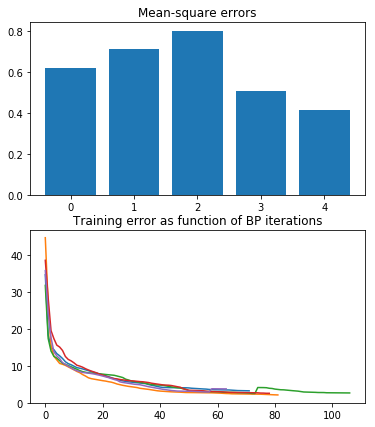

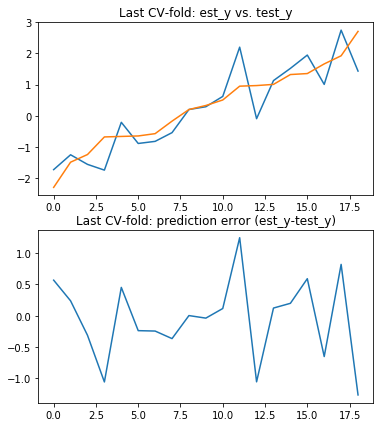

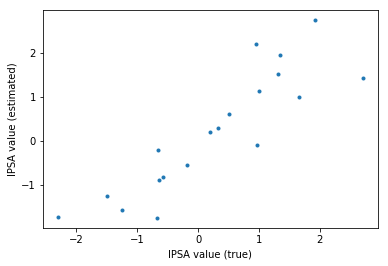

In [35]:
# Print the average least squares error
print('Mean-square error: {0}'.format(np.mean(errors)))

plt.figure(figsize=(6,7));
subplot(2,1,1); plt.bar(range(0,K),errors); title('Mean-square errors');
subplot(2,1,2); plt.plot(error_hist); title('Training error as function of BP iterations');
figure(figsize=(6,7));
subplot(2,1,1); plt.plot(y_est); plot(y_test); title('Last CV-fold: est_y vs. test_y'); 
subplot(2,1,2); plt.plot((y_est-y_test)); title('Last CV-fold: prediction error (est_y-test_y)'); 
plt.show()


# Display scatter plot
figure(1)
#subplot(2,1,1)
plot(y_test, y_est, '.')
#plot(X_r, model.predict(X_r),color='k')
#plot(X_r, y_est, color='blue', linewidth=1)
xlabel('lPSA value (true)'); ylabel('lPSA value (estimated)');
show()

[6.16984899e-03 2.98069151e-03 1.76526010e-02 9.96185879e-04
 6.72159024e-03 1.86792072e-04 1.13161615e-03 2.46915880e-04
 1.83490326e-04 1.09276370e-09 2.40321646e-04 1.35355055e-02
 8.47757727e-04 3.96872031e-04 3.38637722e-04 4.50752890e-03
 1.34467625e-05 1.28084791e-03 1.91599565e-05 6.48448258e-05
 4.63916042e-04 4.07532471e-03 1.13753317e-02 3.76865290e-05
 2.32199793e-04 3.77669741e-03 2.16963119e-08 3.39244142e-04
 2.16142056e-03 3.72116820e-05 1.35479629e-03 1.55956720e-03
 5.47301736e-03 3.54166583e-03 3.52521122e-03 4.91912725e-04
 1.36352554e-02 1.34519618e-05 6.72817197e-03 1.55877775e-08
 2.60128368e-02 7.49345603e-05 1.55283013e-05 1.55261268e-04
 4.11608310e-06 6.82751625e-04 2.53535813e-04 5.69197322e-05
 3.04664905e-05 5.15547509e-05 3.22977057e-03 8.56777528e-04
 2.63314625e-03 2.44871132e-05 7.41358654e-06 6.66706871e-04
 4.36708007e-04 3.74652589e-04 2.67055021e-03 1.27848548e-03
 1.95942407e-03 7.72986822e-04 3.28777711e-05 1.25584869e-05
 1.02793117e-03 3.173025

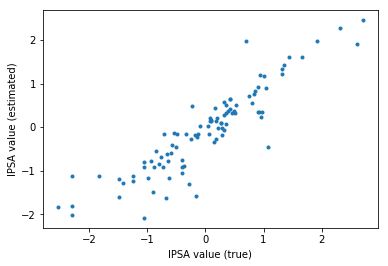

In [36]:
# dummy test of training data error
y_hat = []
dummy_error = []
y_hat = bestnet[0].sim(X1).squeeze()
dummy_error = np.power(y_hat-y ,2).astype(float)/y_train.shape[0]
print(dummy_error)

# Display scatter plot
figure(1)
#subplot(2,1,1)
plot(y, y_hat, '.')
#plot(X_r, model.predict(X_r),color='k')
#plot(X_r, y_est, color='blue', linewidth=1)
xlabel('lPSA value (true)'); ylabel('lPSA value (estimated)');
plt.savefig(base_dir + '/Figures/ANN_Regression_fit_lamda_03.png')
show()


# ANN for regression with correct loop

In [95]:
# Results from the 2-level cross-validation for dtc 
# Errors for each outer tc fold: [15.0, 30.0, 10.526315789473685, 10.526315789473685, 15.789473684210526]
# The errors for the best performing models are: 10.526315789473685, 15.0
## Crossvalidation for decision trees
## The selection of optimal model is based on an average of the inner errors for each model

# Create crossvalidation partition for evaluation
K_outer = 5
K_inner = 5

# Parameters for neural network classifier
n_hidden_units = [15, 2,4,6,8,10]      # number of hidden units
n_train = 6             # number of networks trained in each k-fold
learning_goal = 0.0001     # stop criterion 1 (train mse to be reached)
max_epochs = 512         # stop criterion 2 (max epochs in training)
show_error_freq = 100     # frequency of training status updates

errors = np.zeros(K)*np.nan
gen_error = np.zeros(K)*np.nan
error_hist = np.zeros((max_epochs,K))*np.nan
bestnet = list()

CV_outer = model_selection.KFold(n_splits=K_outer,shuffle=True, random_state=seed)
#CV = model_selection.StratifiedKFold(n_splits=K)

    

# ANN
ANN = []
index_min_lst_ANN = []
min_indices_ANN = []
error_outer_ANN = [] # List for the errors in outer CV fold
dict_inner_ANN = {}
error_inner_ANN = {} # Dict with the errors in the innter CV fold for each tested model
n_hidden_units = [2,4,6,8,10,15]      # number of hidden units
classifier_lst_ANN = []



for count, value in enumerate(n_hidden_units):
    error_inner_ANN['NO_HIDDEN_of_{0}'.format(value)] = []




k=0

for train_outer_index, test_outer_index in CV_outer.split(X1,y):
    print('CV-fold {0} of {1}'.format(k+1,K_outer))
    
    
    # extract training and test set for current CV fold
    X_train_outer = X1[train_outer_index,:]
    y_train_outer = y[train_outer_index]
    X_test_outer = X1[test_outer_index,:]
    y_test_outer = y[test_outer_index]
    
    CV_inner = model_selection.KFold(n_splits=K_inner,shuffle=True, random_state=seed)
    
    kk=0
    
    for train_inner_index, test_inner_index in CV_inner.split(X_train_outer,y_train_outer):
        print('Inner CV-fold {0} of {1}'.format(kk+1,K_inner))

        # extract training and test set for current CV fold
        X_train_inner = X_train_outer[train_inner_index,:]
        y_train_inner = y_train_outer[train_inner_index]
        X_test_inner = X_train_outer[test_inner_index,:]
        y_test_inner = y_train_outer[test_inner_index]
        
#         print(len(X_train_inner))
#         print(len(y_train_inner))
        
    
    
    # ANN Classifier
        best_train_error = np.inf
        for i in range(n_train):
            #print('Training network {0}/{1}...'.format(i+1,n_train))
            # Create randomly initialized network with 2 layers
            #print("testing no hidden = " + str(n_hidden_units[i]))
            ann = nl.net.newff([[-3,3]]*M, [n_hidden_units[i], 1], [nl.trans.TanSig(),nl.trans.PureLin()])
            if i==0:
                bestnet.append(ann)
            # train network
            train_error = ann.train(X_train_inner, y_train_inner.reshape(-1,1), goal=learning_goal, epochs=max_epochs, show=show_error_freq, rr=0.3)
            
            if train_error[-1]<best_train_error:
                bestnet[kk]=ann
                best_train_error = train_error[-1]
                error_hist[range(len(train_error)),kk] = train_error
                best_no_neurons = n_hidden_units[i]
                #print(best_no_neurons)
            
        #print('Best train error: {0}...'.format(best_train_error))
        #print('Optimal number of hidden neurons: {0}...'.format(best_no_neurons))
        y_est = bestnet[kk].sim(X_test_inner).squeeze()
        
        #print(2)
        errors[kk] = np.power(y_est-y_test_inner,2).sum().astype(float)/y_test_inner.shape[0]
        #errors[kk] = 100*(y_est!=y_test).sum().astype(float)/y_test.shape[0]
        #gen_error[kk] = 100 * (y_est-y_test).sum().astype(float)/y_test.shape[0]
        #print(gen_error[kk])
        #errors[k] = - y_test * np.log(y_est) - (1 - y_test) * np.log (1 - y_est)
        #print(gen_error[kk])
        errorANN_inner = (np.power(y_est-y_test_inner,2).sum().astype(float)/y_test_inner.shape[0])**(0.5)
        error_inner_ANN['NO_HIDDEN_of_{0}'.format(best_no_neurons)].append(errorANN_inner) # add errors for each fold to each model
        
        #print(best_no_neurons)
        #print(errorANN_inner)
        #print(value)
        #print(3)
        
        #print('error_inner_ANN is ' + str(error_inner_ANN))
        kk +=1    
    
         
  



    # ANN
    # Find the KNN value with minimum average error value
    
    #{k: v for k, v in error_inner_ANN.items() if v is not None}
    
    error_inner_ANN = {k: [9999999] if not v else v for k, v in error_inner_ANN.items() }
    
    for key in error_inner_ANN.keys():
        index_min_lst_ANN.append((error_inner_ANN[key]))
        
    print('Inner_error_values are:' + str(index_min_lst_ANN))
    
    print(type(index_min_lst_ANN))
    #index_min_lst_ANN = [x for x in index_min_lst_ANN if x != []]
    print('Inner_error_values are after clean:' + str(index_min_lst_ANN))
    index_min_ANN = np.argmin(index_min_lst_ANN) #Find the index of the minimum error value
    top_count_ANN = index_min_ANN
    min_indices_ANN.append(index_min_ANN) 
        
    index_min_lst_ANN = [] # Clear for next CV fold
    
    for key in error_inner_ANN.keys():
        error_inner_ANN[key] = [] # Clear for next CV fold
        
      
    print('The index of optimal ANN value is: ' + str(top_count_ANN))
    
    optimal_no_neurons = n_hidden_units[top_count_ANN]
    
    print('The optimal number of neurons in ANN value across inner CV folds is: ' + str(optimal_no_neurons))
    
            
    #y_ANN_outer = knclassifierOuter.predict(X_test_outer);
    y_est = bestnet[k].sim(X_test_outer).squeeze()
    
    errorANN_outer = (np.power(y_est-y_test_outer,2).sum().astype(float)/y_test_outer.shape[0])**(0.5)
    #error_outer_KNN.append(errorKNN_outer)
    error_outer_ANN.append(errorANN_outer)
    print('Errors for each outer CV fold: ' + str(error_outer_ANN))
    k += 1
    

    

error_ANN = error_outer_ANN


CV-fold 1 of 5
Inner CV-fold 1 of 5
Inner CV-fold 2 of 5
Inner CV-fold 3 of 5
Inner CV-fold 4 of 5
Inner CV-fold 5 of 5
Inner_error_values are:[[9999999], [9999999], [0.6591603524162566], [9999999], [0.9163519259607619], [1.0107188001537102, 0.9498985263289657, 0.7409217601589427]]
<class 'list'>
Inner_error_values are after clean:[[9999999], [9999999], [0.6591603524162566], [9999999], [0.9163519259607619], [1.0107188001537102, 0.9498985263289657, 0.7409217601589427]]
The index of optimal ANN value is: 2
The optimal number of neurons in ANN value across inner CV folds is: 6
Errors for each outer CV fold: [0.8235503456056368]
CV-fold 2 of 5
Inner CV-fold 1 of 5
Inner CV-fold 2 of 5
Inner CV-fold 3 of 5
Inner CV-fold 4 of 5
Inner CV-fold 5 of 5
Inner_error_values are:[[9999999], [9999999], [9999999], [9999999], [0.6476441327784921, 0.9240350042794041], [0.7131610900376019, 0.8471500865169662, 0.6716419105513415]]
<class 'list'>
Inner_error_values are after clean:[[9999999], [9999999], [9

In [96]:
print(error_ANN)
# Final generalization error for ANN
ANN_error = (len(y_test_outer)/N*np.mat(error_ANN)).sum()
print('Outer error of ANN is' + str(ANN_error))

[0.8235503456056368, 0.7979615481306048, 0.9871712289618215, 0.827934850480106, 0.954231929747159]
Outer error of ANN is0.8600633830472292


Mean-square error: 1.0526928518120404


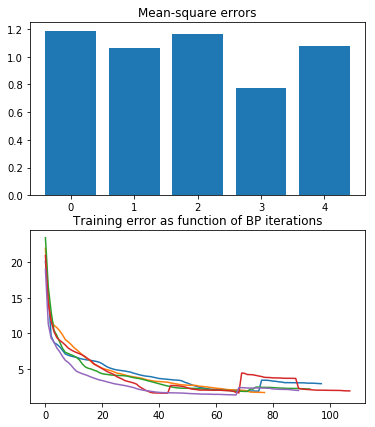

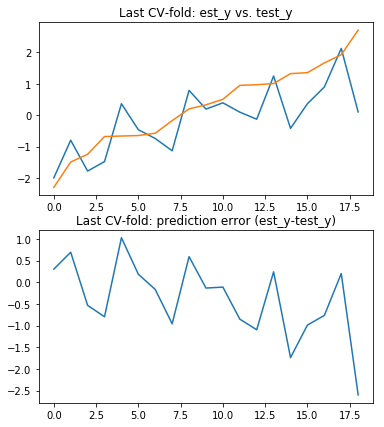

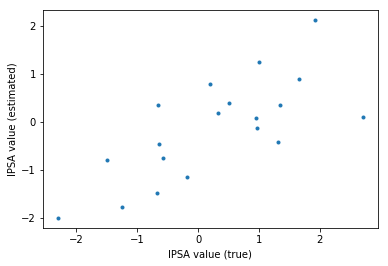

In [97]:
# Print the average least squares error
print('Mean-square error: {0}'.format(np.mean(errors)))

plt.figure(figsize=(6,7));
subplot(2,1,1); plt.bar(range(0,K),errors); title('Mean-square errors');
subplot(2,1,2); plt.plot(error_hist); title('Training error as function of BP iterations');
figure(figsize=(6,7));
subplot(2,1,1); plt.plot(y_est); plot(y_test_outer); title('Last CV-fold: est_y vs. test_y'); 
subplot(2,1,2); plt.plot((y_est-y_test_outer)); title('Last CV-fold: prediction error (est_y-test_y)'); 
plt.show()


# Display scatter plot
figure(1)
#subplot(2,1,1)
plot(y_test_outer, y_est, '.')
#plot(X_r, model.predict(X_r),color='k')
#plot(X_r, y_est, color='blue', linewidth=1)
xlabel('lPSA value (true)'); ylabel('lPSA value (estimated)');
show()

[1.29530397e-01 1.25956220e-04 8.06817279e-04 2.12978919e-05
 6.89512480e-03 2.67793368e-04 1.58362824e-02 5.04446898e-02
 4.75807538e-04 4.30778016e-04 5.00411276e-04 9.01266784e-05
 1.23330560e-03 2.34173999e-05 1.83157466e-05 8.37491094e-05
 2.96662071e-06 1.07974008e-03 3.62994772e-04 1.92024128e-06
 4.75662212e-08 3.91067618e-03 1.93832349e-02 1.34110630e-02
 1.87885172e-05 1.07922064e-04 2.00294244e-04 2.26863671e-03
 5.13895657e-03 3.70152964e-06 3.73186039e-04 1.20963262e-05
 1.69132604e-05 1.65471126e-03 4.10836087e-03 5.29638914e-03
 7.24432876e-06 1.27923086e-02 3.71286029e-03 6.10965498e-03
 1.76706444e-05 1.76038686e-04 2.79629703e-04 1.89839331e-03
 2.28604621e-04 8.98568365e-04 5.61324565e-05 1.65279794e-04
 2.15754788e-05 1.05753100e-04 8.58807792e-05 5.25520667e-05
 1.74442348e-03 6.15802151e-04 1.67448491e-03 1.72909645e-04
 1.09719546e-06 1.30911813e-05 2.08921665e-04 6.51828316e-05
 2.29897086e-04 8.26057323e-03 2.84778818e-05 1.87308673e-05
 7.62026427e-04 4.247465

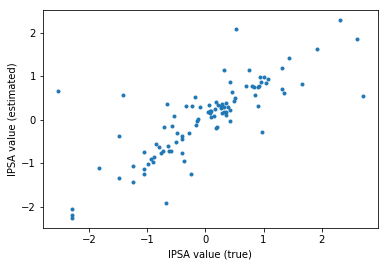

In [98]:
# dummy test of training data error
y_hat = []
dummy_error = []
y_hat = bestnet[0].sim(X1).squeeze()
dummy_error = np.power(y_hat-y ,2).astype(float)/y_train.shape[0]
print(dummy_error)

# Display scatter plot
figure(1)
#subplot(2,1,1)
plot(y, y_hat, '.')
#plot(X_r, model.predict(X_r),color='k')
#plot(X_r, y_est, color='blue', linewidth=1)
xlabel('lPSA value (true)'); ylabel('lPSA value (estimated)');
plt.savefig(base_dir + '/Figures/ANN_Regression_fit_lamda_03.png')
show()


## Credibility interval - comparison of regression models

In [82]:
from scipy import stats

## Crossvalidation
K = K_outer #thus 5
CV = model_selection.KFold(n_splits=K,shuffle=True, random_state=seed)

# Initialize variables
Error_base_line = np.asarray(Error_test_b)
Error_model_1 = np.asarray(Error_test_fs) #LinReg
Error_model_2 = np.asarray(error_ANN) #ANN

# Comparison of Baseline model with model 1

# Test if classifiers are significantly different using methods in section 9.3.3
# by computing credibility interval. Notice this can also be accomplished by computing the p-value using
# [tstatistic, pvalue] = stats.ttest_ind(Error_logreg,Error_dectree)
# and test if the p-value is less than alpha=0.05. 
z = (Error_base_line-Error_model_1)
zb = z.mean()
nu = K-1
sig =  (z-zb).std()  / np.sqrt(K-1)
alpha = 0.05

zL = zb + sig * stats.t.ppf(alpha/2, nu);
zH = zb + sig * stats.t.ppf(1-alpha/2, nu);

if zL <= 0 and zH >= 0 :
    print('Model 1 and baseline model are not significantly different')        
else:
    print('Model 1 and baseline model are significantly different.')
print('zb:' +str(zb))
print('sig:' + str(sig))
print('zL:' + str(zL))
print('zH:' +str(zH))

# Comparison of Baseline model with model 2

# Test if classifiers are significantly different using methods in section 9.3.3
# by computing credibility interval. Notice this can also be accomplished by computing the p-value using
# [tstatistic, pvalue] = stats.ttest_ind(Error_logreg,Error_dectree)
# and test if the p-value is less than alpha=0.05. 
z = (Error_base_line-Error_model_2)
zb = z.mean()
nu = K-1
sig =  (z-zb).std()  / np.sqrt(K-1)
alpha = 0.05

zL = zb + sig * stats.t.ppf(alpha/2, nu);
zH = zb + sig * stats.t.ppf(1-alpha/2, nu);

if zL <= 0 and zH >= 0 :
    print('Baseline model and Model 2 are not significantly different')        
else:
    print('Baseline model and Model 2 are significantly different.')
print('zb:' +str(zb))
print('sig:' + str(sig))
print('zL:' + str(zL))
print('zH:' +str(zH))

# Comparison of model 1 with model 2

# Test if classifiers are significantly different using methods in section 9.3.3
# by computing credibility interval. Notice this can also be accomplished by computing the p-value using
# [tstatistic, pvalue] = stats.ttest_ind(Error_logreg,Error_dectree)
# and test if the p-value is less than alpha=0.05. 
z = (Error_model_1-Error_model_2)
zb = z.mean()
nu = K-1
sig =  (z-zb).std()  / np.sqrt(K-1)
alpha = 0.05

zL = zb + sig * stats.t.ppf(alpha/2, nu);
zH = zb + sig * stats.t.ppf(1-alpha/2, nu);

if zL <= 0 and zH >= 0 :
    print('Model 1 and Model 2 are not significantly different')        
else:
    print('Model 1 and Model 2 are significantly different.')
print('zb:' +str(zb))
print('sig:' + str(sig))
print('zL:' + str(zL))
print('zH:' +str(zH))


Model 1 and baseline model are significantly different.
zb:0.349262974464123
sig:0.08638750035226599
zL:0.10941282196080093
zH:0.589113126967445
Baseline model and Model 2 are not significantly different
zb:0.15862422913902835
sig:0.08687779604691624
zL:-0.082587202445805
zH:0.3998356607238616
Model 1 and Model 2 are significantly different.
zb:-0.19063874532509473
sig:0.06065394264818307
zL:-0.3590410875015907
zH:-0.022236403148598816
